# 프로젝트 설명

본 프로젝트는 당뇨병 수치 데이터와 캐글(Kaggle) 경진대회에서 제공하는 자전거 대여량 데이터셋에 다변량 선형회귀 모델을 적용하여 예측정확도를 계산해보고, 예측한 결과를 시각화 해보고자 한다. 당뇨병 수치 데이터를 사용할 때는 manually 회귀 모델을 설계하고 손실함수와 기울기를 계산하는 함수를 구현했으며, 자전거 대여량 데이터셋에는 sci-kit leanrn 라이브러리의 LinearRegression메서드를 사용해서 다변량 선형회귀 모델의 예측 정확도를 계산하고 시각화했다.

### 패키지 임포트

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### 손수 설계하는 선형회귀, 당뇨병 수치를 맞춰보자!

#### 데이터 가져오기

In [79]:
diabetes = load_diabetes()
diabetes.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [80]:
df_X= diabetes.data
df_y = diabetes.target
print(df_X.shape)
print(df_y.shape)

(442, 10)
(442,)


#### 상관관계 확인
목표하고자하는 loss 값에 도달하기위해 target 데이터와 상관관계가 적은 특성을 제거하면 loss가 줄을거라고 생각해서 상관관계를 확인했다.
target 데이터를 예측하는데 방해가 되는, 불필요한 특성을 제거하기 위한 기준으로 상관관계를 활용했다.

In [81]:
data = load_diabetes(as_frame=True)

In [82]:
data['data']['target'] = data['target']
data['data']

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


In [83]:
data['data'].corrwith(data['data']['target'])

age       0.187889
sex       0.043062
bmi       0.586450
bp        0.441484
s1        0.212022
s2        0.174054
s3       -0.394789
s4        0.430453
s5        0.565883
s6        0.382483
target    1.000000
dtype: float64

상관관계의 절대값이 적은 컬럼을 제거하고 돌려봤을 때, loss값이 유의미하게 줄어드는 결과를 확인하지 못했지만, 정답데이터와 예측한 데이터를 시각화 할 때 직관적으로 양의 상관관계가 있는 것이 확인되었다.

In [84]:
#df_X = np.delete(df_X, [0,1,4,5],axis =1)

#### 모델에 입력할 데이터 X 준비하기

In [85]:
df_X = np.array(df_X)
df_X

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

#### 모델에 예측할 데이터 y 준비하기

In [86]:
df_y = np.array(df_y)
df_y

array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
       128.,  52.,  37., 170., 170.,  61., 144.,  52., 128.,  71., 163.,
       150.,  97., 160., 178.,  48., 270., 202., 111.,  85.,  42., 170.,
       200., 252., 113., 143.,  51.,  52., 210.,  65., 141.,  55., 134.,
        42., 111.,  98., 164.,  48.,  96.,  90., 162., 150., 279.,  92.,
        83., 128., 102., 302., 198.,  95.,  53., 134., 144., 232.,  81.,
       104.,  59., 246., 297., 258., 229., 275., 281., 179., 200., 200.,
       173., 180.,  84., 121., 161.,  99., 109., 115., 268., 274., 158.,
       107.,  83., 103., 272.,  85., 280., 336., 281., 118., 317., 235.,
        60., 174., 259., 178., 128.,  96., 126., 28

#### train 데이터와 test 데이터로 분리하기

In [87]:
train_input, test_input, train_target, test_target = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

#### 모델 준비하기

In [88]:
np.random.seed(42)
num_feature = train_input.shape[1]
W = np.random.rand(num_feature)
b = np.random.rand()

def model(X, W, b):
    predictions = 0
    for i in range(num_feature):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

In [89]:
def MSE(a, b):
    mse = ((a - b) ** 2).mean()
    return mse

In [90]:
def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

In [91]:
loss(train_input, W, b, train_target)

29690.148096407873

In [92]:
def gradient(X, W, b, y):
    N = len(W)
    
    y_pred = model(X, W, b)
    
    dW = 1/N * 2 * X.T.dot(y_pred - y)
        
    db = 2 * (y_pred - y).mean()
    return dW, db

In [93]:
LEARNING_RATE = 0.01

In [94]:
losses = []

for i in range(1, 1001):
    dW, db = gradient(train_input, W, b, train_target)
    W -= LEARNING_RATE * dW
    b -= LEARNING_RATE * db
    L = loss(train_input, W, b, train_target)
    losses.append(L)
    if i % 100 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

Iteration 100 : Loss 4688.9455
Iteration 200 : Loss 3674.4467
Iteration 300 : Loss 3388.8479
Iteration 400 : Loss 3233.7693
Iteration 500 : Loss 3135.8683
Iteration 600 : Loss 3069.6513
Iteration 700 : Loss 3023.3220
Iteration 800 : Loss 2990.3260
Iteration 900 : Loss 2966.5649
Iteration 1000 : Loss 2949.3086


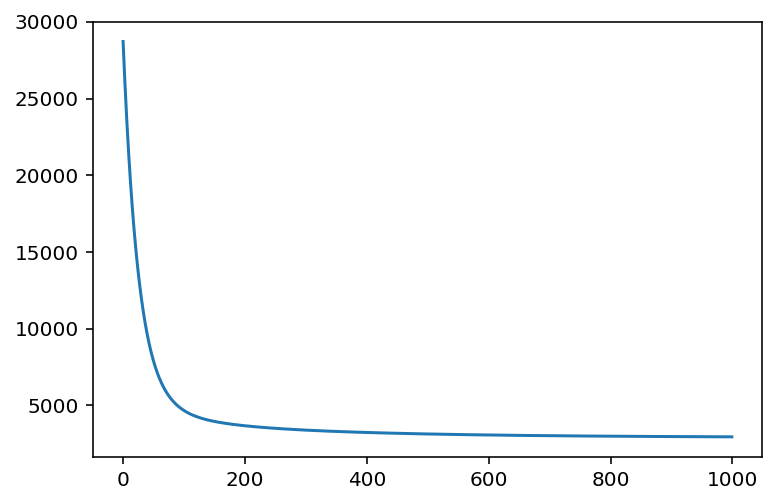

In [95]:
plt.plot(losses)
plt.show()

In [96]:
W, b

(array([  48.22812489, -170.02777021,  470.55540051,  306.64069582,
         -51.57093654, -100.13790088, -209.74077226,  145.38602918,
         350.83664371,  133.04487253]),
 151.49096064317663)

#### test 데이터에 대한 성능 확인하기

In [97]:
prediction = model(test_input, W, b)
mse = loss(test_input, W, b, test_target)
mse

2867.311487959944

#### 정답 데이터와 예측한 데이터 시각화하기

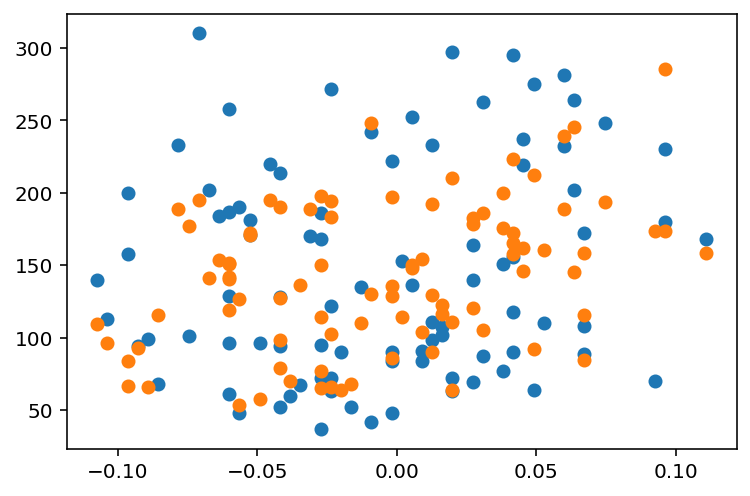

In [98]:
plt.scatter(test_input[:, 0], test_target)
plt.scatter(test_input[:, 0], prediction)
plt.show()

#### 상관관계를 기반으로 target과 상관관계가 적은, 불필요한 feature를 제거한 데이터에 대한 결과
목표하고자하는 loss 값에 도달하기위해 target 데이터와 상관관계가 적은 특성을 제거하면 loss가 줄을거라고 생각해서 상관관계를 확인했다.
target 데이터를 예측하는데 방해가 되는, 불필요한 특성을 제거하기 위한 기준으로 상관관계를 활용했다.

In [99]:
data = load_diabetes(as_frame=True)

In [100]:
data['data']['target'] = data['target']
data['data']

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


In [101]:
data['data'].corrwith(data['data']['target'])

age       0.187889
sex       0.043062
bmi       0.586450
bp        0.441484
s1        0.212022
s2        0.174054
s3       -0.394789
s4        0.430453
s5        0.565883
s6        0.382483
target    1.000000
dtype: float64

상관관계의 절대값이 적은 컬럼을 제거하고 돌려봤을 때, loss값이 유의미하게 줄어드는 결과를 확인하지 못했지만, 정답데이터와 예측한 데이터를 시각화 할 때 직관적으로 양의 상관관계가 있는 것이 확인되었다.

In [102]:
df_X_omit = np.delete(df_X, [0,1,4,5],axis =1)

Iteration 100 : Loss 3068.4478
Iteration 200 : Loss 3038.9096
Iteration 300 : Loss 3031.9899
Iteration 400 : Loss 3029.7498
Iteration 500 : Loss 3028.9853
Iteration 600 : Loss 3028.7223
Iteration 700 : Loss 3028.6318
Iteration 800 : Loss 3028.6006
Iteration 900 : Loss 3028.5899
Iteration 1000 : Loss 3028.5862


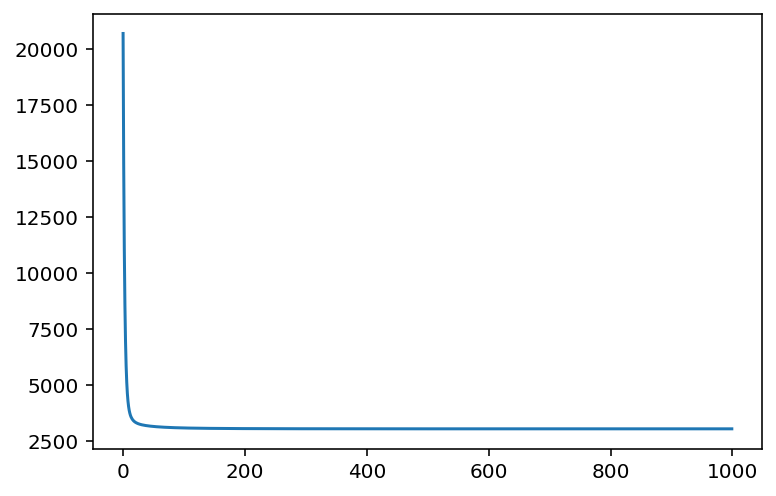

[ 596.87967869  292.26262386 -318.20299795 -164.55535614  479.52012588
   37.8448954 ] 151.44851215313184
Loss of test dataset : 2930.8280362242167


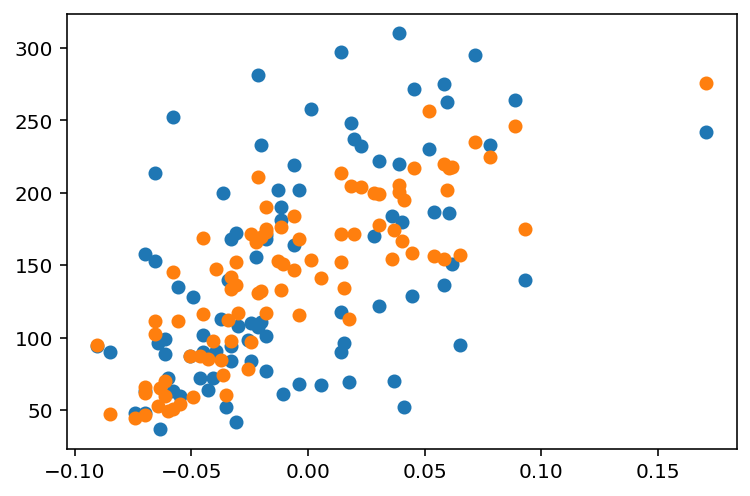

In [110]:
train_input, test_input, train_target, test_target = train_test_split(df_X_omit, df_y, test_size=0.2, random_state=42)

#### 모델 준비하기

np.random.seed(42)
num_feature = train_input.shape[1]
W = np.random.rand(num_feature)
b = np.random.rand()

def model(X, W, b):
    predictions = 0
    for i in range(num_feature):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

def MSE(a, b):
    mse = ((a - b) ** 2).mean()
    return mse

def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

def gradient(X, W, b, y):
    N = len(W)
    
    y_pred = model(X, W, b)
    
    dW = 1/N * 2 * X.T.dot(y_pred - y)
        
    db = 2 * (y_pred - y).mean()
    return dW, db

LEARNING_RATE = 0.1

losses = []

for i in range(1, 1001):
    dW, db = gradient(train_input, W, b, train_target)
    W -= LEARNING_RATE * dW
    b -= LEARNING_RATE * db
    L = loss(train_input, W, b, train_target)
    losses.append(L)
    if i % 100 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

plt.plot(losses)
plt.show()

print(W, b)

#### test 데이터에 대한 성능 확인하기

prediction = model(test_input, W, b)
mse = loss(test_input, W, b, test_target)
print(f'Loss of test dataset : {mse}')

#### 정답 데이터와 예측한 데이터 시각화하기

plt.scatter(test_input[:, 0], test_target)
plt.scatter(test_input[:, 0], prediction)
plt.show()

#### Target 데이터를 정규화하여 감소한 loss값 확인하기

In [106]:
df_y_renorm = (df_y - df_y.mean()) / (df_y.std())**0.5
df_y_renorm.head()

array([-1.29167689e-01, -8.78984837e+00, -1.26873094e+00,  6.13843017e+00,
       -1.95246889e+00, -6.28280922e+00, -1.61059991e+00, -1.01573243e+01,
       -4.80137700e+00,  1.79898879e+01, -5.82698393e+00, -9.47358632e+00,
        3.06160940e+00,  3.74534735e+00, -3.88972641e+00,  2.14995881e+00,
        1.58017718e+00, -9.26861962e-01, -6.28280922e+00,  1.80808983e+00,
       -9.58754264e+00, -1.17527128e+01, -9.58754264e+00,  1.05827268e+01,
        3.63139103e+00,  5.68260487e+00, -1.72455624e+00, -7.65028512e+00,
       -2.40829418e+00,  1.49130672e+01, -2.63620683e+00, -1.06131496e+01,
        2.15225340e+01, -7.42237247e+00, -9.92941162e+00, -5.71302760e+00,
        1.28618533e+01,  1.41153729e+01,  1.13804211e+01, -7.08050350e+00,
       -5.94094025e+00, -1.10689749e+01, -1.03852369e+01, -6.85259085e+00,
        1.21781154e+01, -1.12968875e+01,  4.31512898e+00, -1.15477461e+00,
       -8.78984837e+00, -1.15477461e+00,  3.26657610e-01,  8.30360034e+00,
       -1.06131496e+01, -

Iteration 100 : Loss 56.0051
Iteration 200 : Loss 47.9252
Iteration 300 : Loss 44.1945
Iteration 400 : Loss 42.1166
Iteration 500 : Loss 40.8042
Iteration 600 : Loss 39.9174
Iteration 700 : Loss 39.2977
Iteration 800 : Loss 38.8570
Iteration 900 : Loss 38.5402
Iteration 1000 : Loss 38.3104


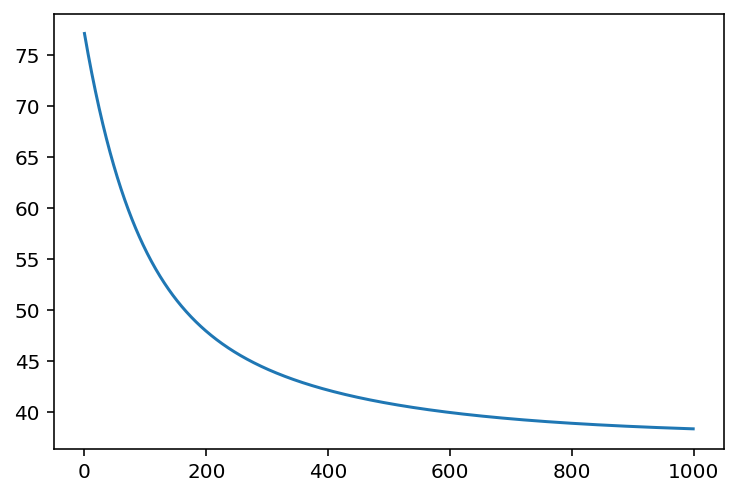

[  5.3061117  -19.1371023   53.59855653  34.97911069  -5.92291625
 -11.34830164 -23.51006428  16.9135223   39.9577705   15.02920655] -0.07235785865476188
Loss of test dataset : 37.219623272740904


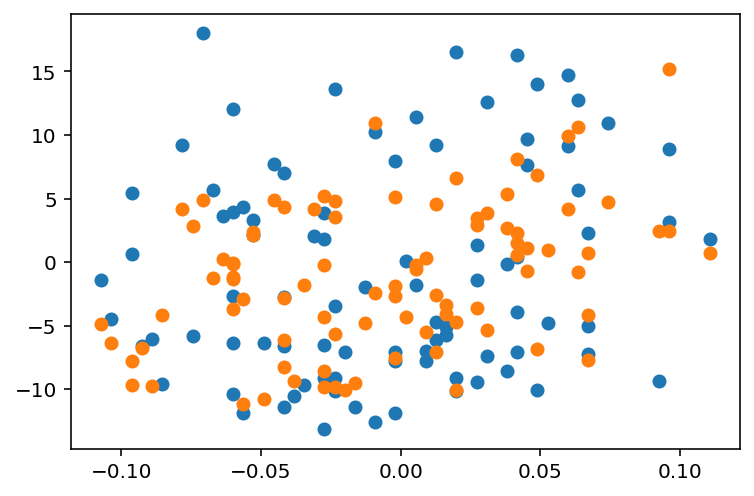

In [111]:
train_input, test_input, train_target, test_target = train_test_split(df_X, df_y_renorm, test_size=0.2, random_state=42)

#### 모델 준비하기

np.random.seed(42)
num_feature = train_input.shape[1]
W = np.random.rand(num_feature)
b = np.random.rand()

def model(X, W, b):
    predictions = 0
    for i in range(num_feature):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

def MSE(a, b):
    mse = ((a - b) ** 2).mean()
    return mse

def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

def gradient(X, W, b, y):
    N = len(W)
    
    y_pred = model(X, W, b)
    
    dW = 1/N * 2 * X.T.dot(y_pred - y)
        
    db = 2 * (y_pred - y).mean()
    return dW, db

LEARNING_RATE = 0.01

losses = []

for i in range(1, 1001):
    dW, db = gradient(train_input, W, b, train_target)
    W -= LEARNING_RATE * dW
    b -= LEARNING_RATE * db
    L = loss(train_input, W, b, train_target)
    losses.append(L)
    if i % 100 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

plt.plot(losses)
plt.show()

print(W, b)

#### test 데이터에 대한 성능 확인하기

prediction = model(test_input, W, b)
mse = loss(test_input, W, b, test_target)
print(f'Loss of test dataset : {mse}')

#### 정답 데이터와 예측한 데이터 시각화하기

plt.scatter(test_input[:, 0], test_target)
plt.scatter(test_input[:, 0], prediction)
plt.show()

### 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

#### 데이터 가져오기

In [160]:
bike_sharing = pd.read_csv("/aiffel/aiffel/bike_regression/data/train.csv")
bike_sharing

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [161]:
bike_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


#### datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

In [162]:
bike_sharing.datetime = pd.to_datetime(bike_sharing.datetime)
bike_sharing['year'] = bike_sharing.datetime.dt.year
bike_sharing['month'] = bike_sharing.datetime.dt.month
bike_sharing['day'] = bike_sharing.datetime.dt.day
bike_sharing['hour'] = bike_sharing.datetime.dt.hour
bike_sharing['minute'] = bike_sharing.datetime.dt.minute
bike_sharing['second'] = bike_sharing.datetime.dt.second

'''요일 정보 가져오기
출처 : https://god9ma.tistory.com/27

프로젝트 이름대로
1) 날씨 좋은
2) 월요일
3) 오후 세 시에
자전거 대여량을 확인하기 위해 추가적으로 요일정보를 가져왔다.
'''
bike_sharing['dayofweek']= bike_sharing["datetime"].dt.dayofweek

bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


#### year, month, day, hour, minute, second 데이터 개수 시각화하기

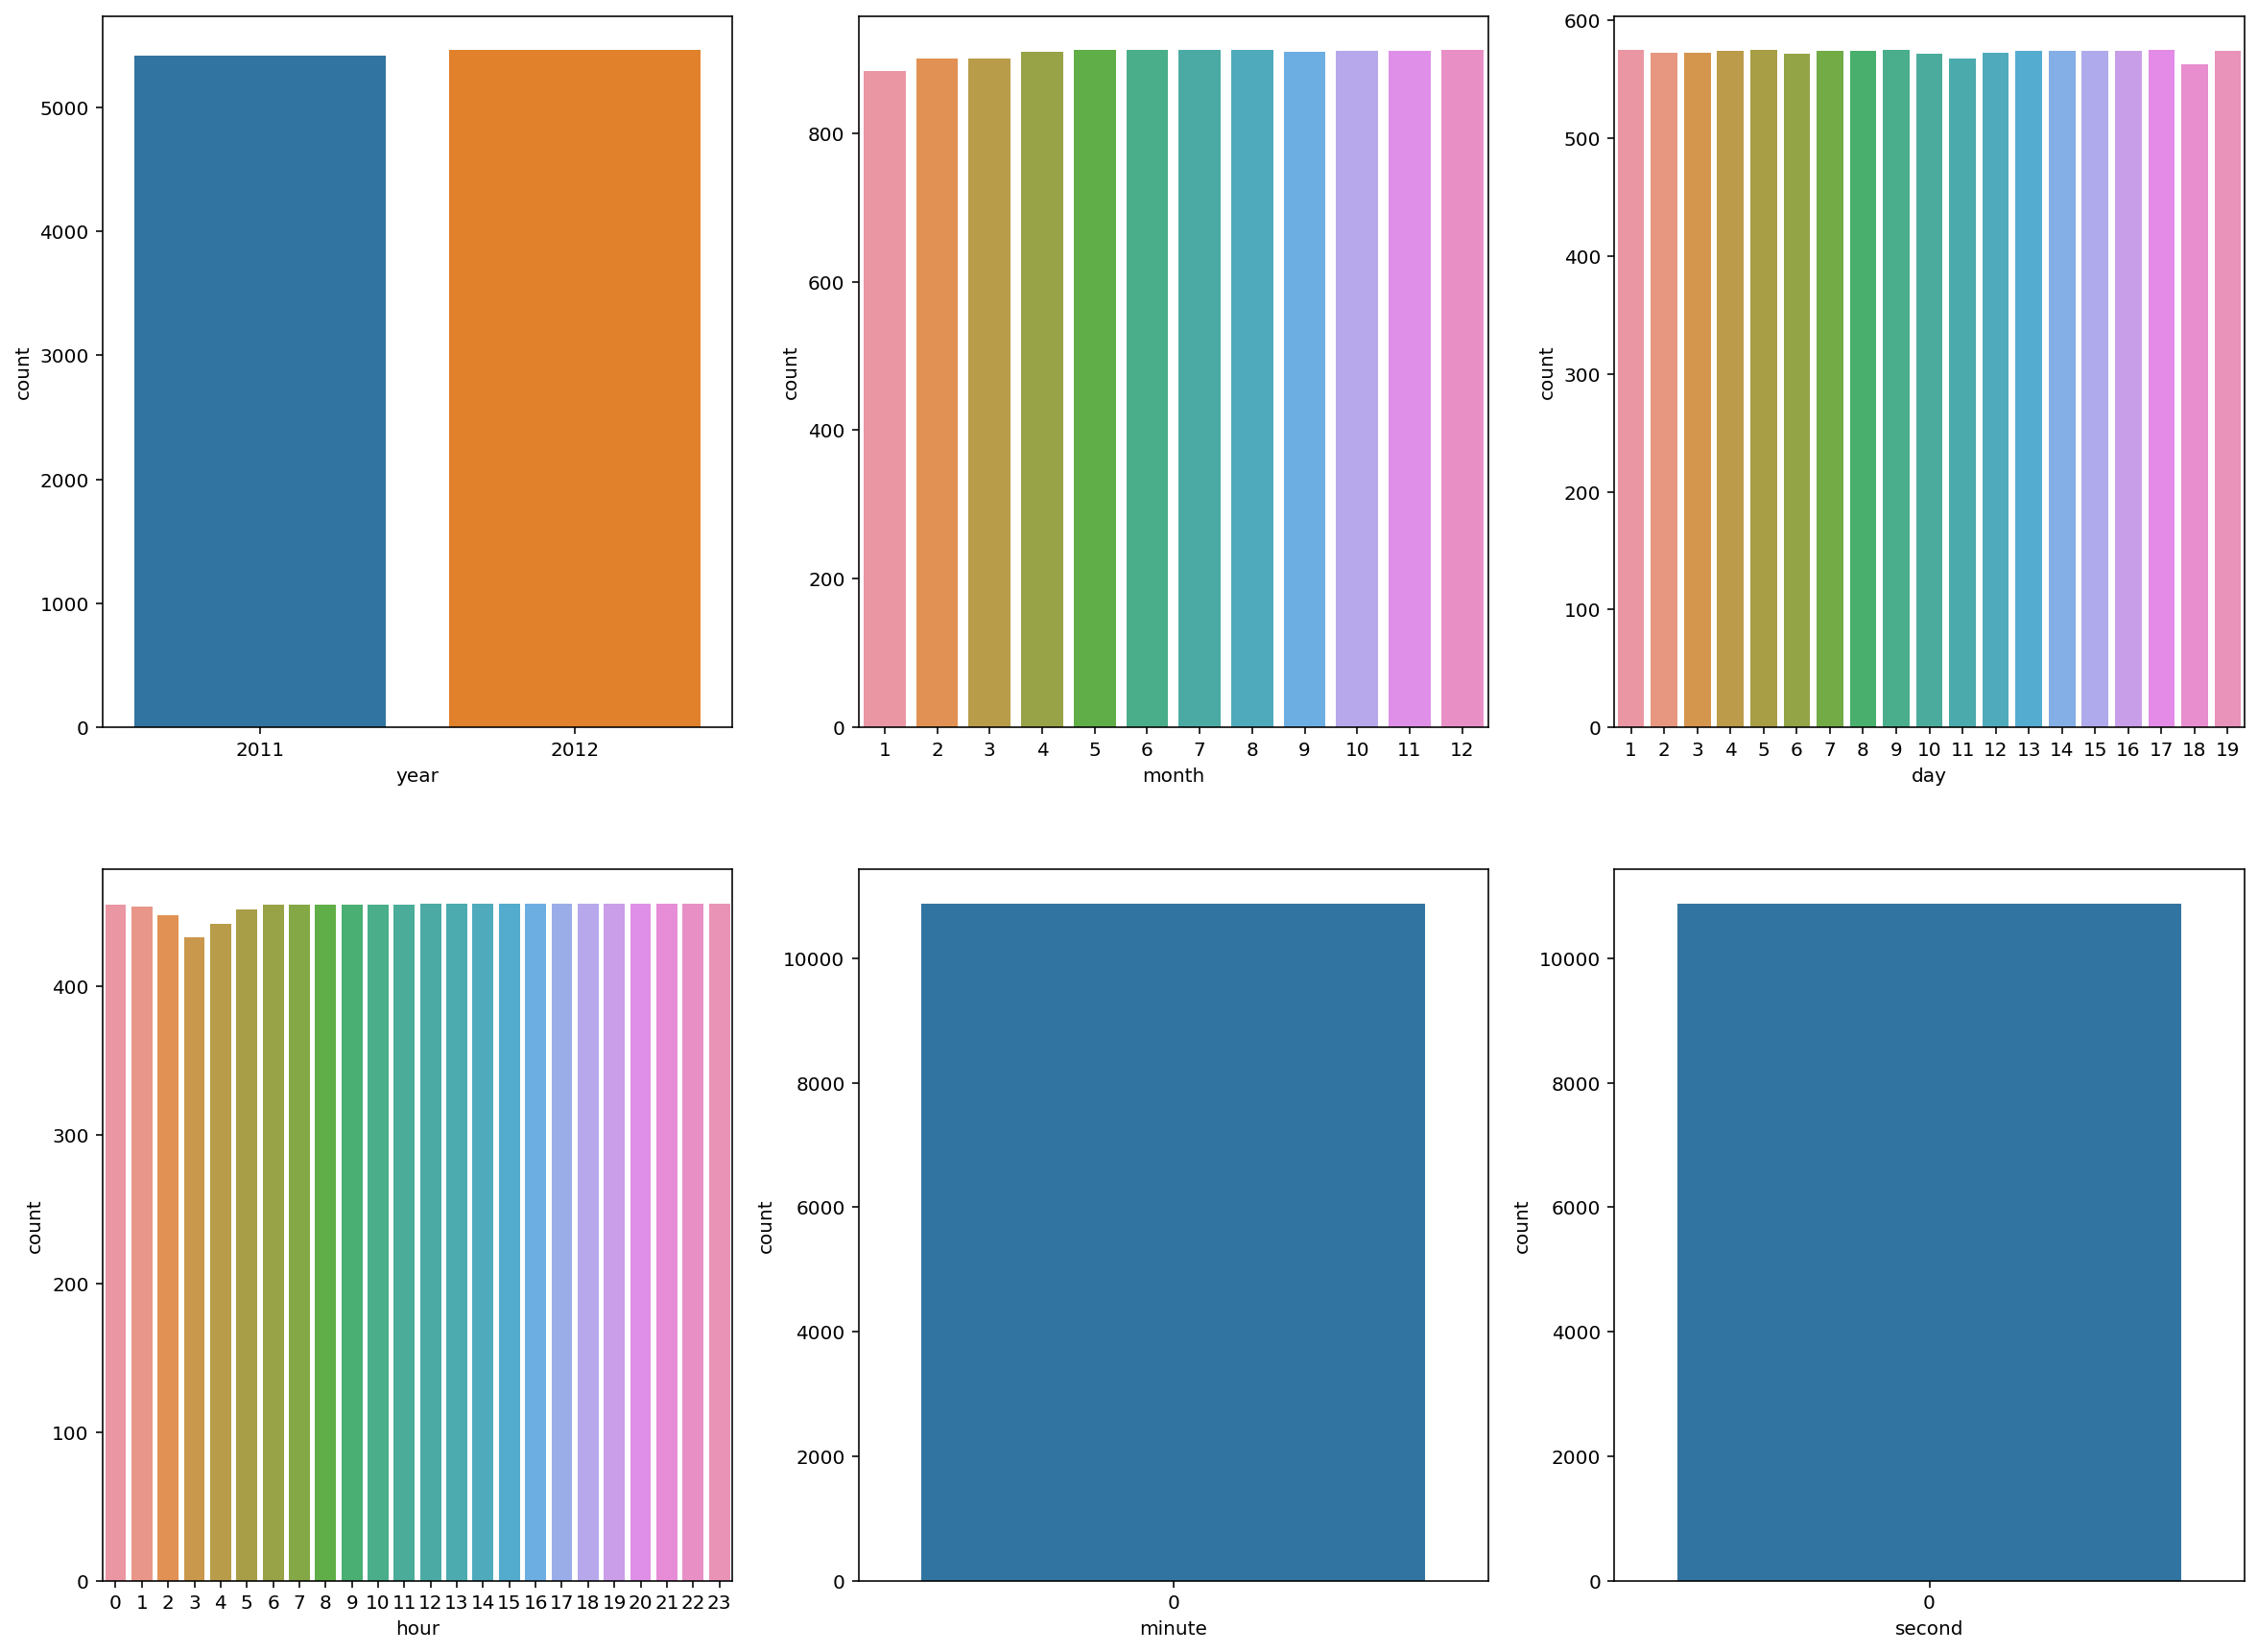

In [163]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(2,3,1)
sns.countplot(x = 'year', data = bike_sharing)

ax2 = fig.add_subplot(2,3,2)
sns.countplot(x = 'month', data = bike_sharing)

ax3 = fig.add_subplot(2,3,3)
sns.countplot(x = 'day', data = bike_sharing)

ax4 = fig.add_subplot(2,3,4)
sns.countplot(x = 'hour', data = bike_sharing)

ax5 = fig.add_subplot(2,3,5)
sns.countplot(x = 'minute', data = bike_sharing)

ax1 = fig.add_subplot(2,3,6)
sns.countplot(x = 'second', data = bike_sharing)

plt.show()

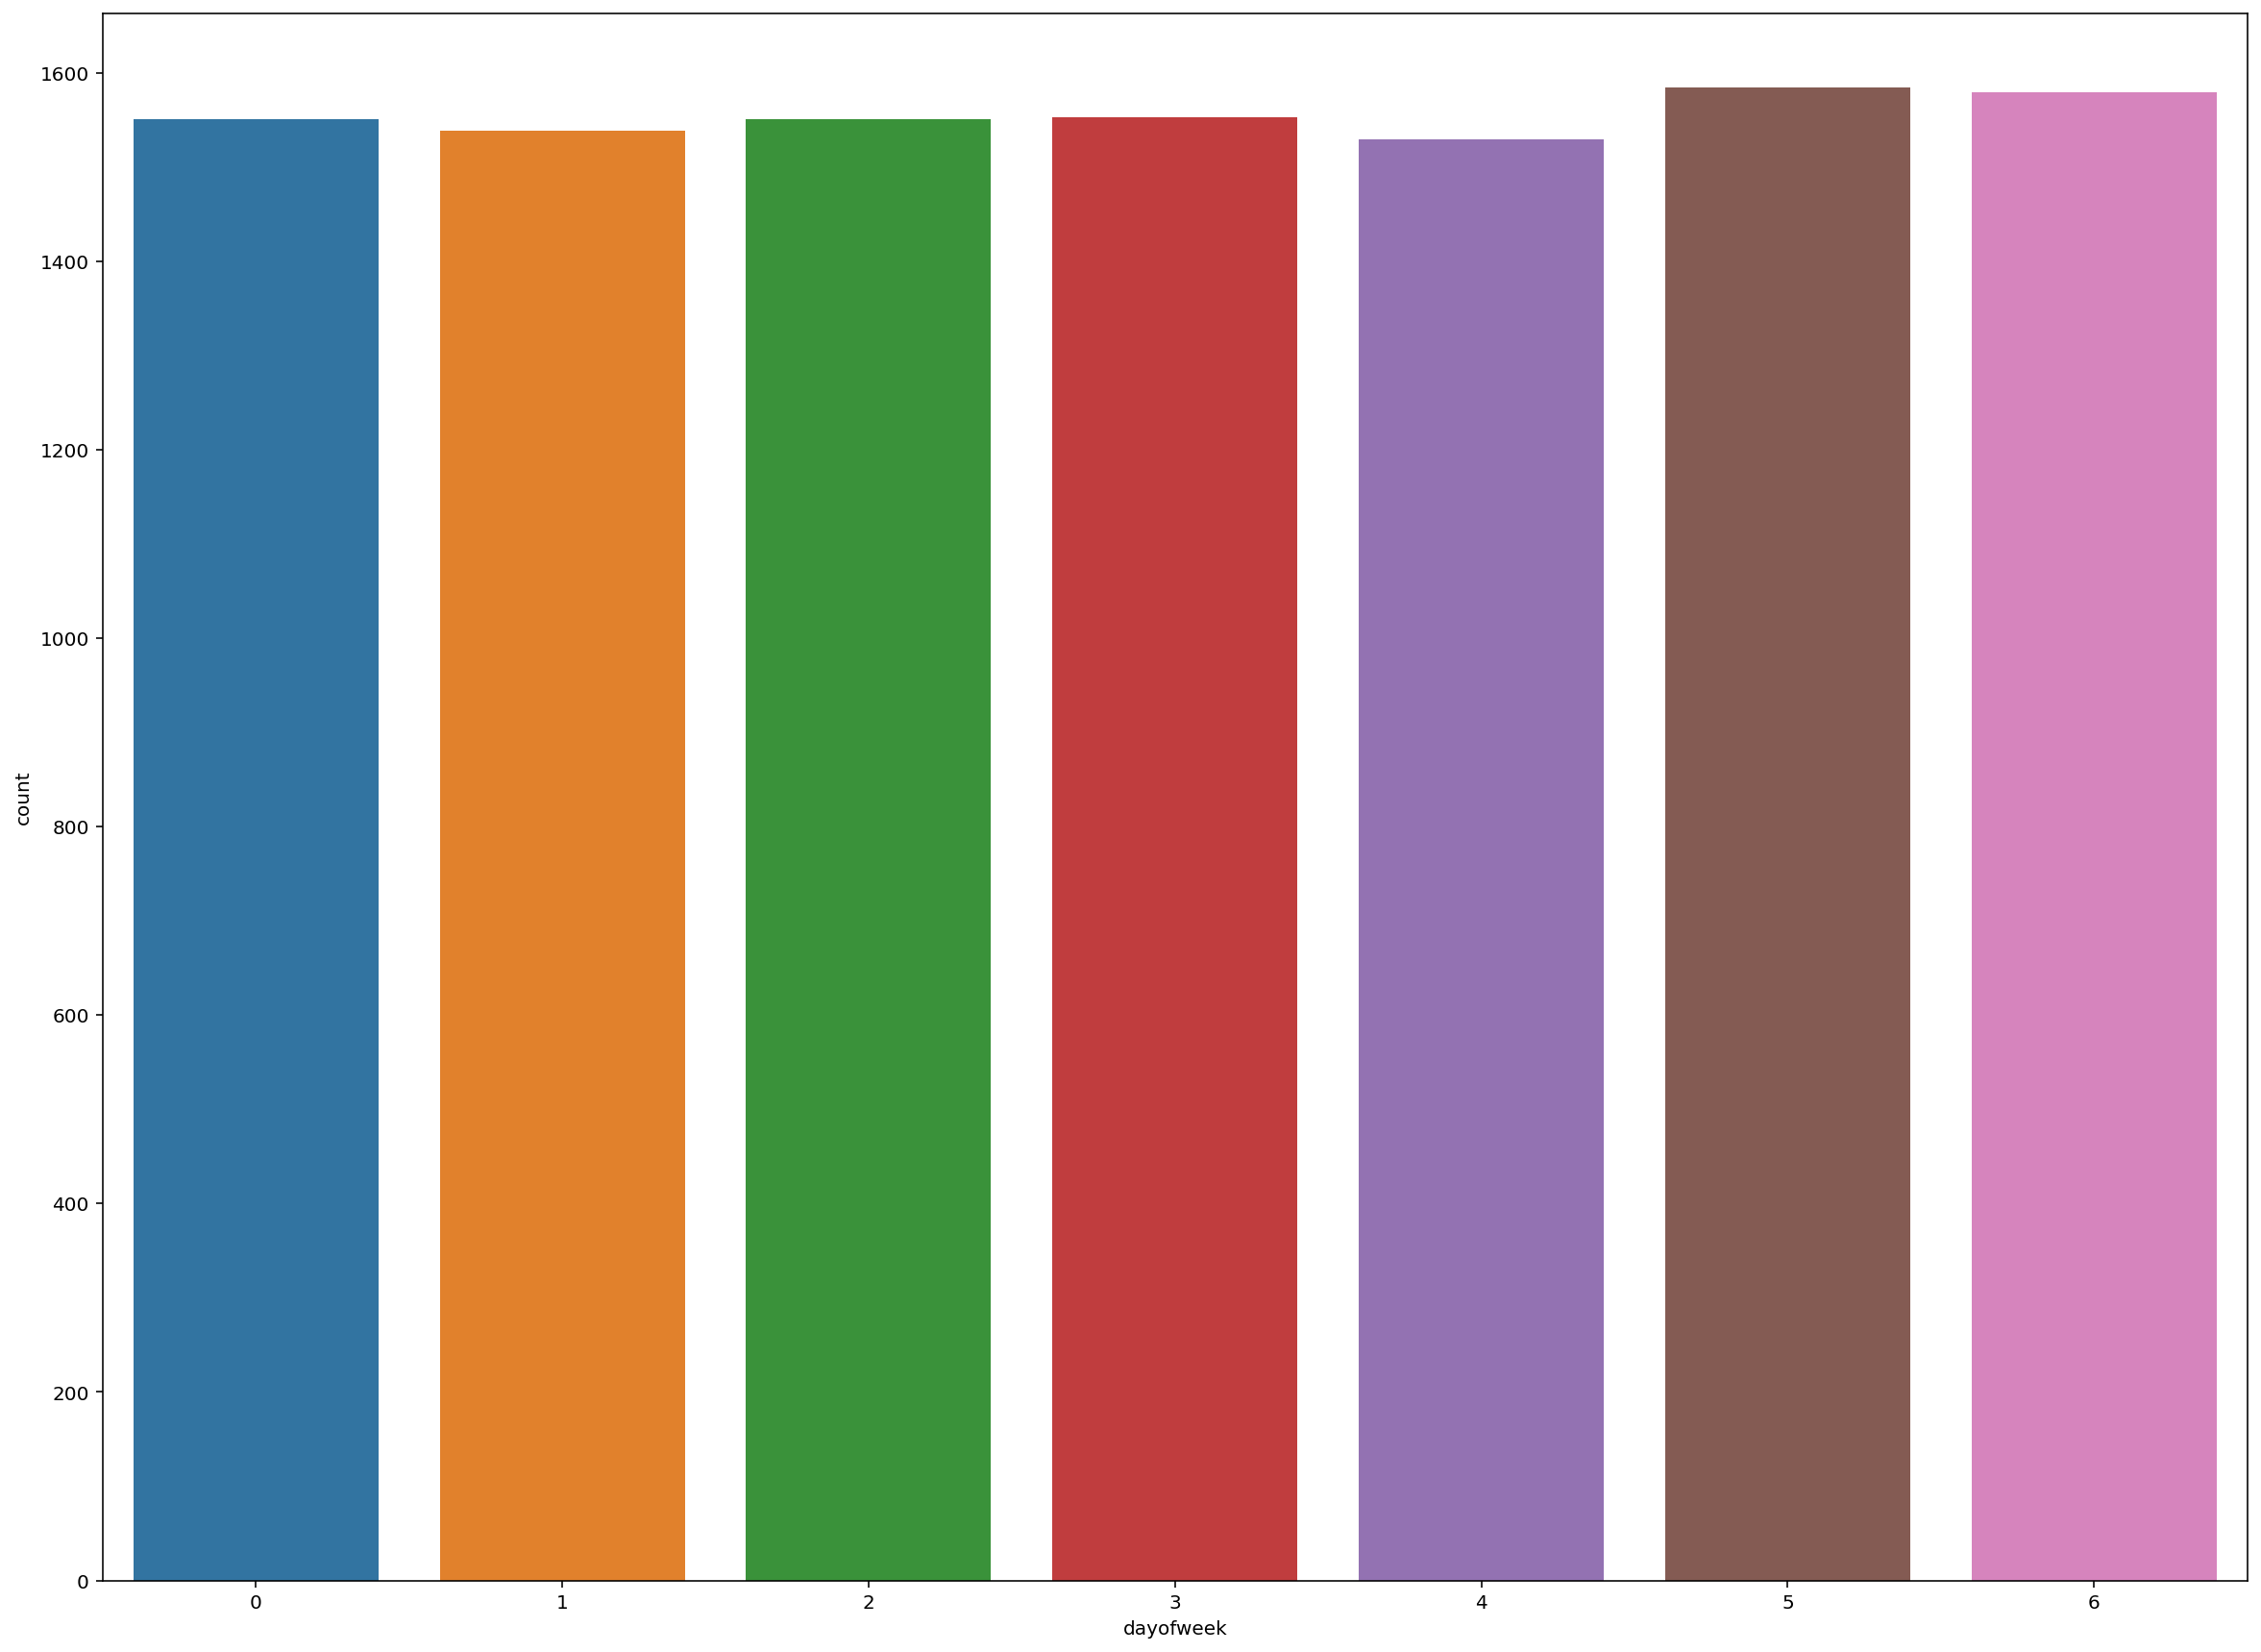

In [164]:
# 요일별로 데이터 크기 확인
# 요일 - 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일)
fig = plt.figure(figsize=(20,15))
sns.countplot(x = 'dayofweek', data = bike_sharing)
plt.show()

#### X, y 컬럼 선택 및 train/test 데이터 분리

In [165]:
bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [185]:
'''
datetime 컬럼은 6개의 속성으로 나누고 원핫 인코딩했으므로 필요가 없고,
casual과 registered컬럼은 합치면 count가 되기 때문에 삭제했다.
출처 : https://dsbook.tistory.com/328
'''
bike_sharing_dumm = pd.get_dummies(bike_sharing, columns = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'holiday', 'workingday', 'season', 'weather'])
bike_sharing_dumm.drop(columns=["datetime", "casual","registered"],inplace=True)
bike_sharing_dumm

,temp,atemp,humidity,windspeed,count,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,16,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,40,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,32,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,13,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,336,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,241,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,168,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,129,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [176]:
X = bike_sharing_dumm.drop(columns='count')
y = bike_sharing_dumm['count']
print(X.shape)
print(y.shape)

(10886, 82)
(10886,)


#### X, y 컬럼 선택 및 train/test 데이터 분리

In [177]:
train_input, test_input, train_target, test_target = train_test_split(X, y, random_state = 42)

#### LinearRegression 모델 학습

In [178]:
lr = LinearRegression()
lr.fit(train_input, train_target)

LinearRegression()

#### 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산

In [179]:
pred = lr.predict(test_input)

In [180]:
mse = mean_squared_error(test_target, pred)
rmse = mean_squared_error(test_target, pred)**0.5
print(mse)
print(rmse)

10107.04241742797
100.53378744197381


#### x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기

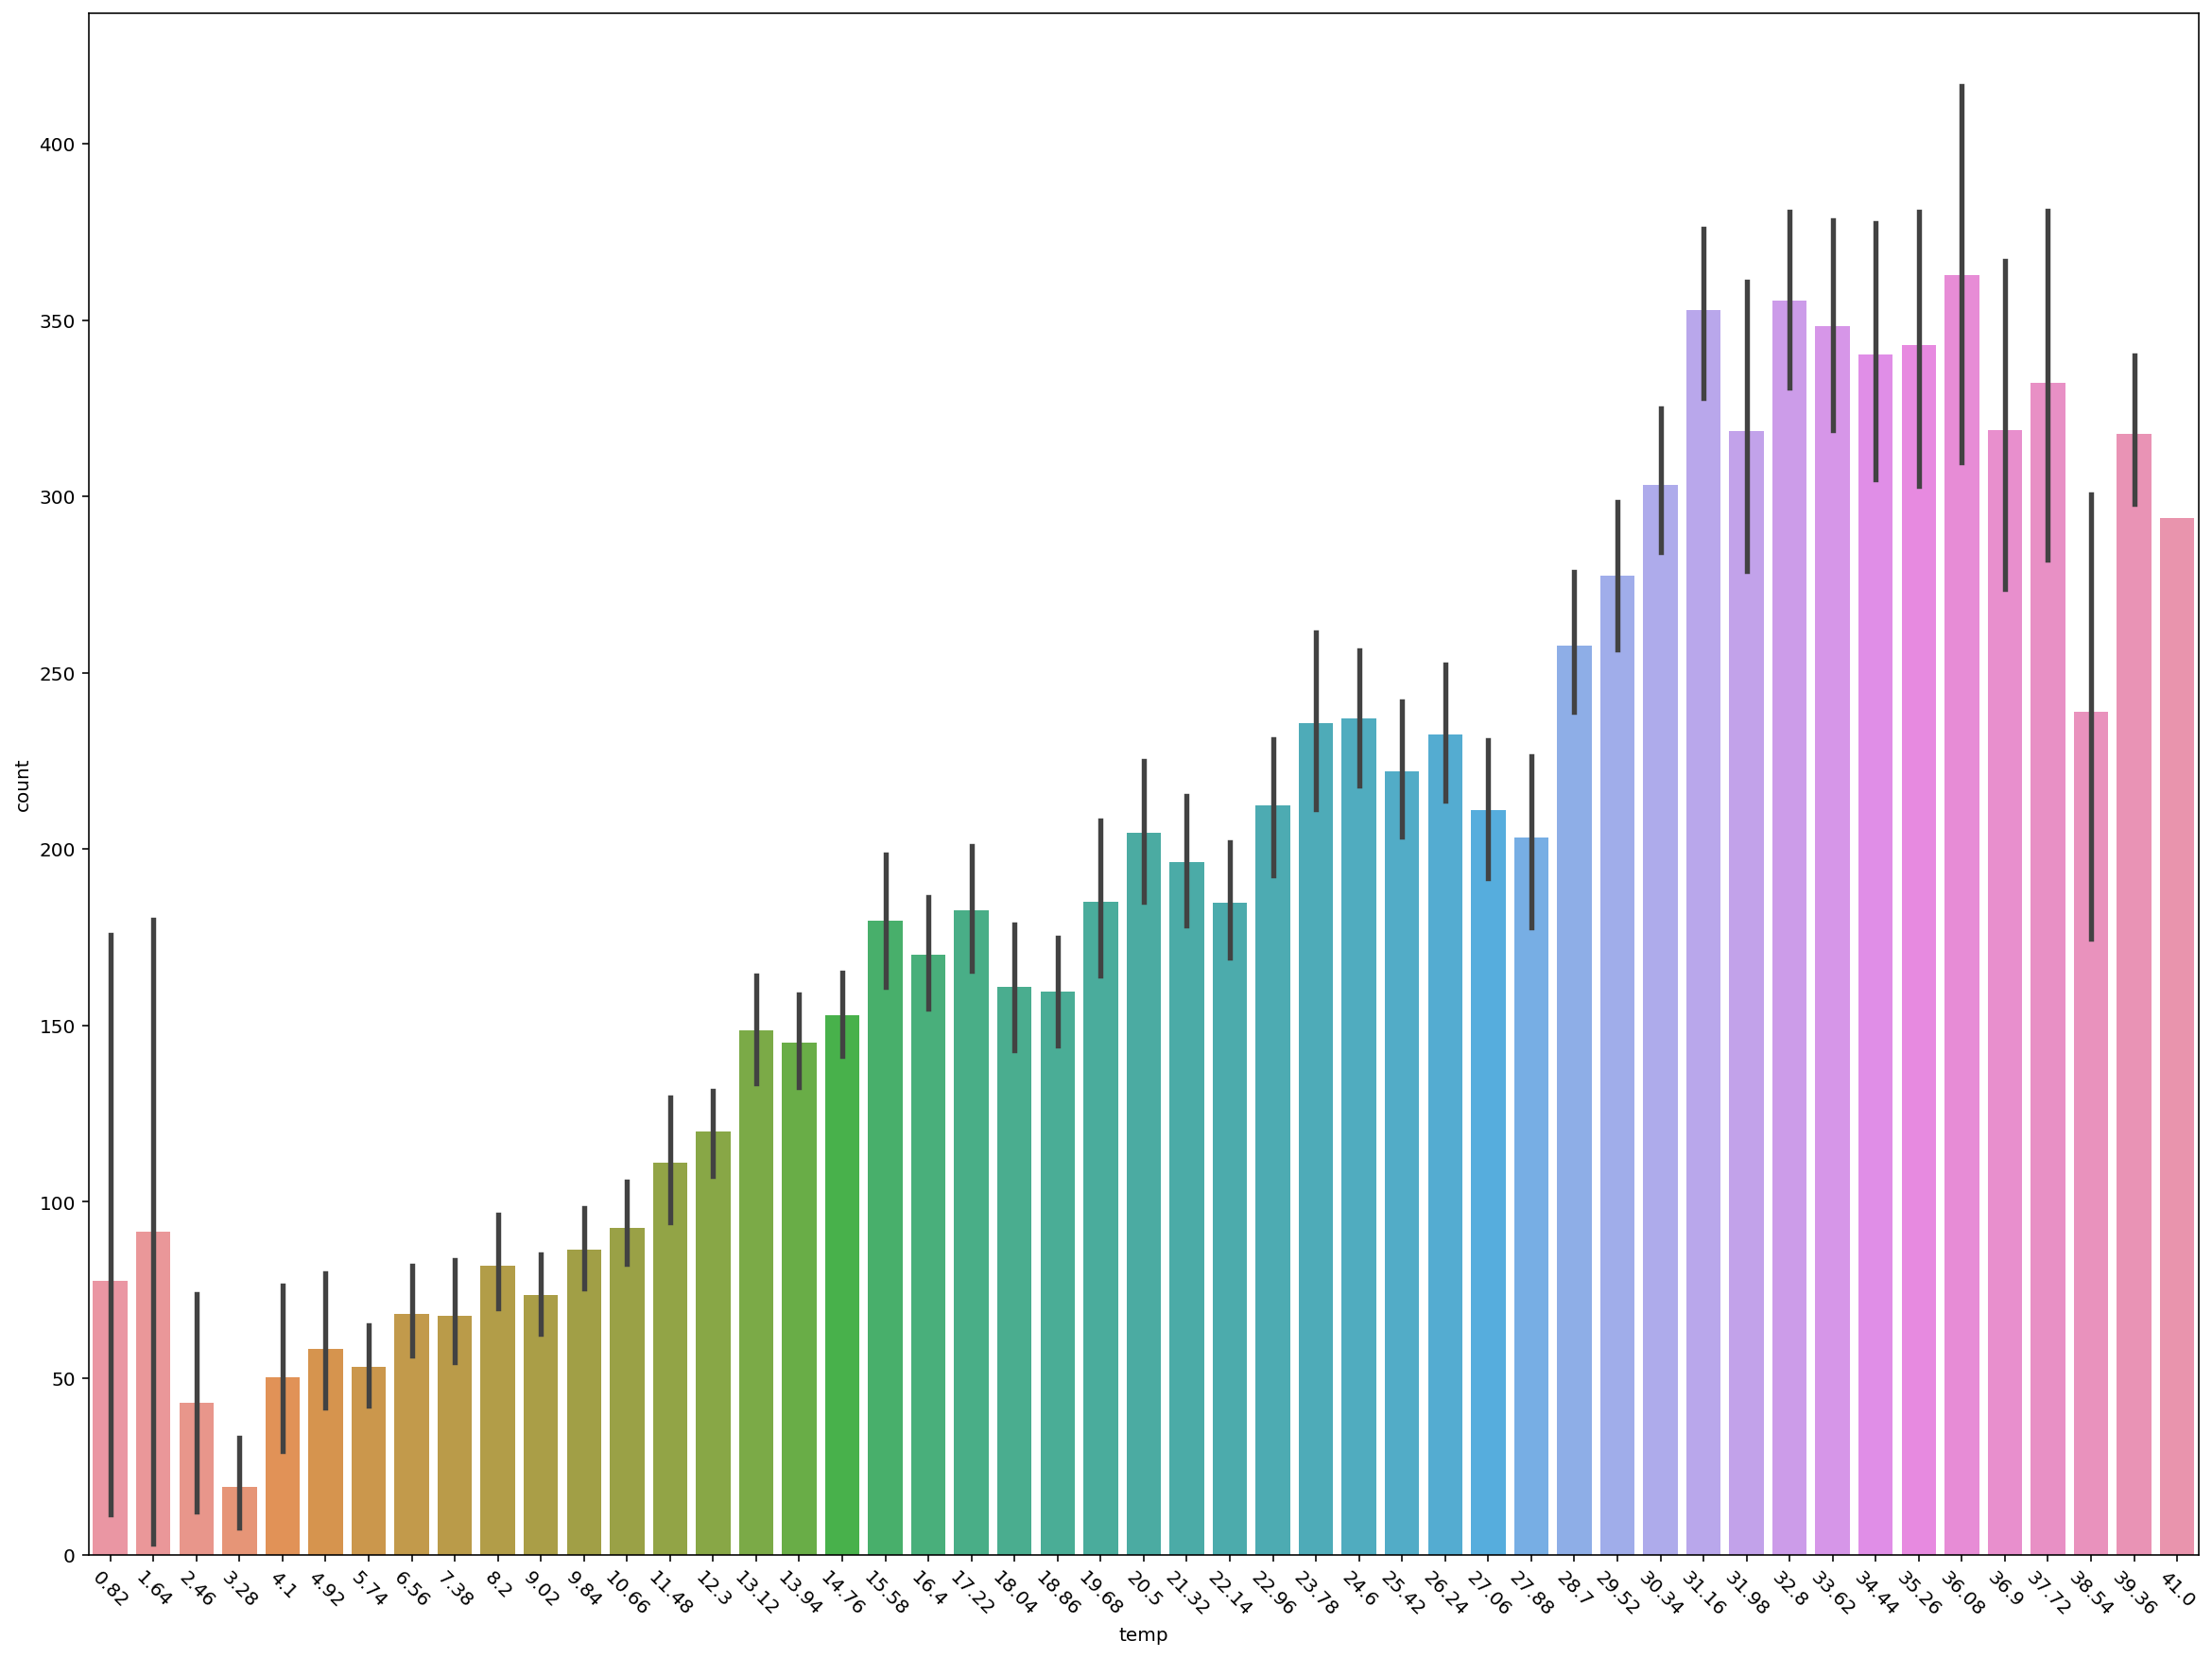

In [197]:
fig = plt.figure(figsize=(20,15))
sns.barplot( x = bike_sharing_dumm['temp'], y = bike_sharing_dumm['count'] )
plt.xticks(rotation = - 45 )
plt.show()

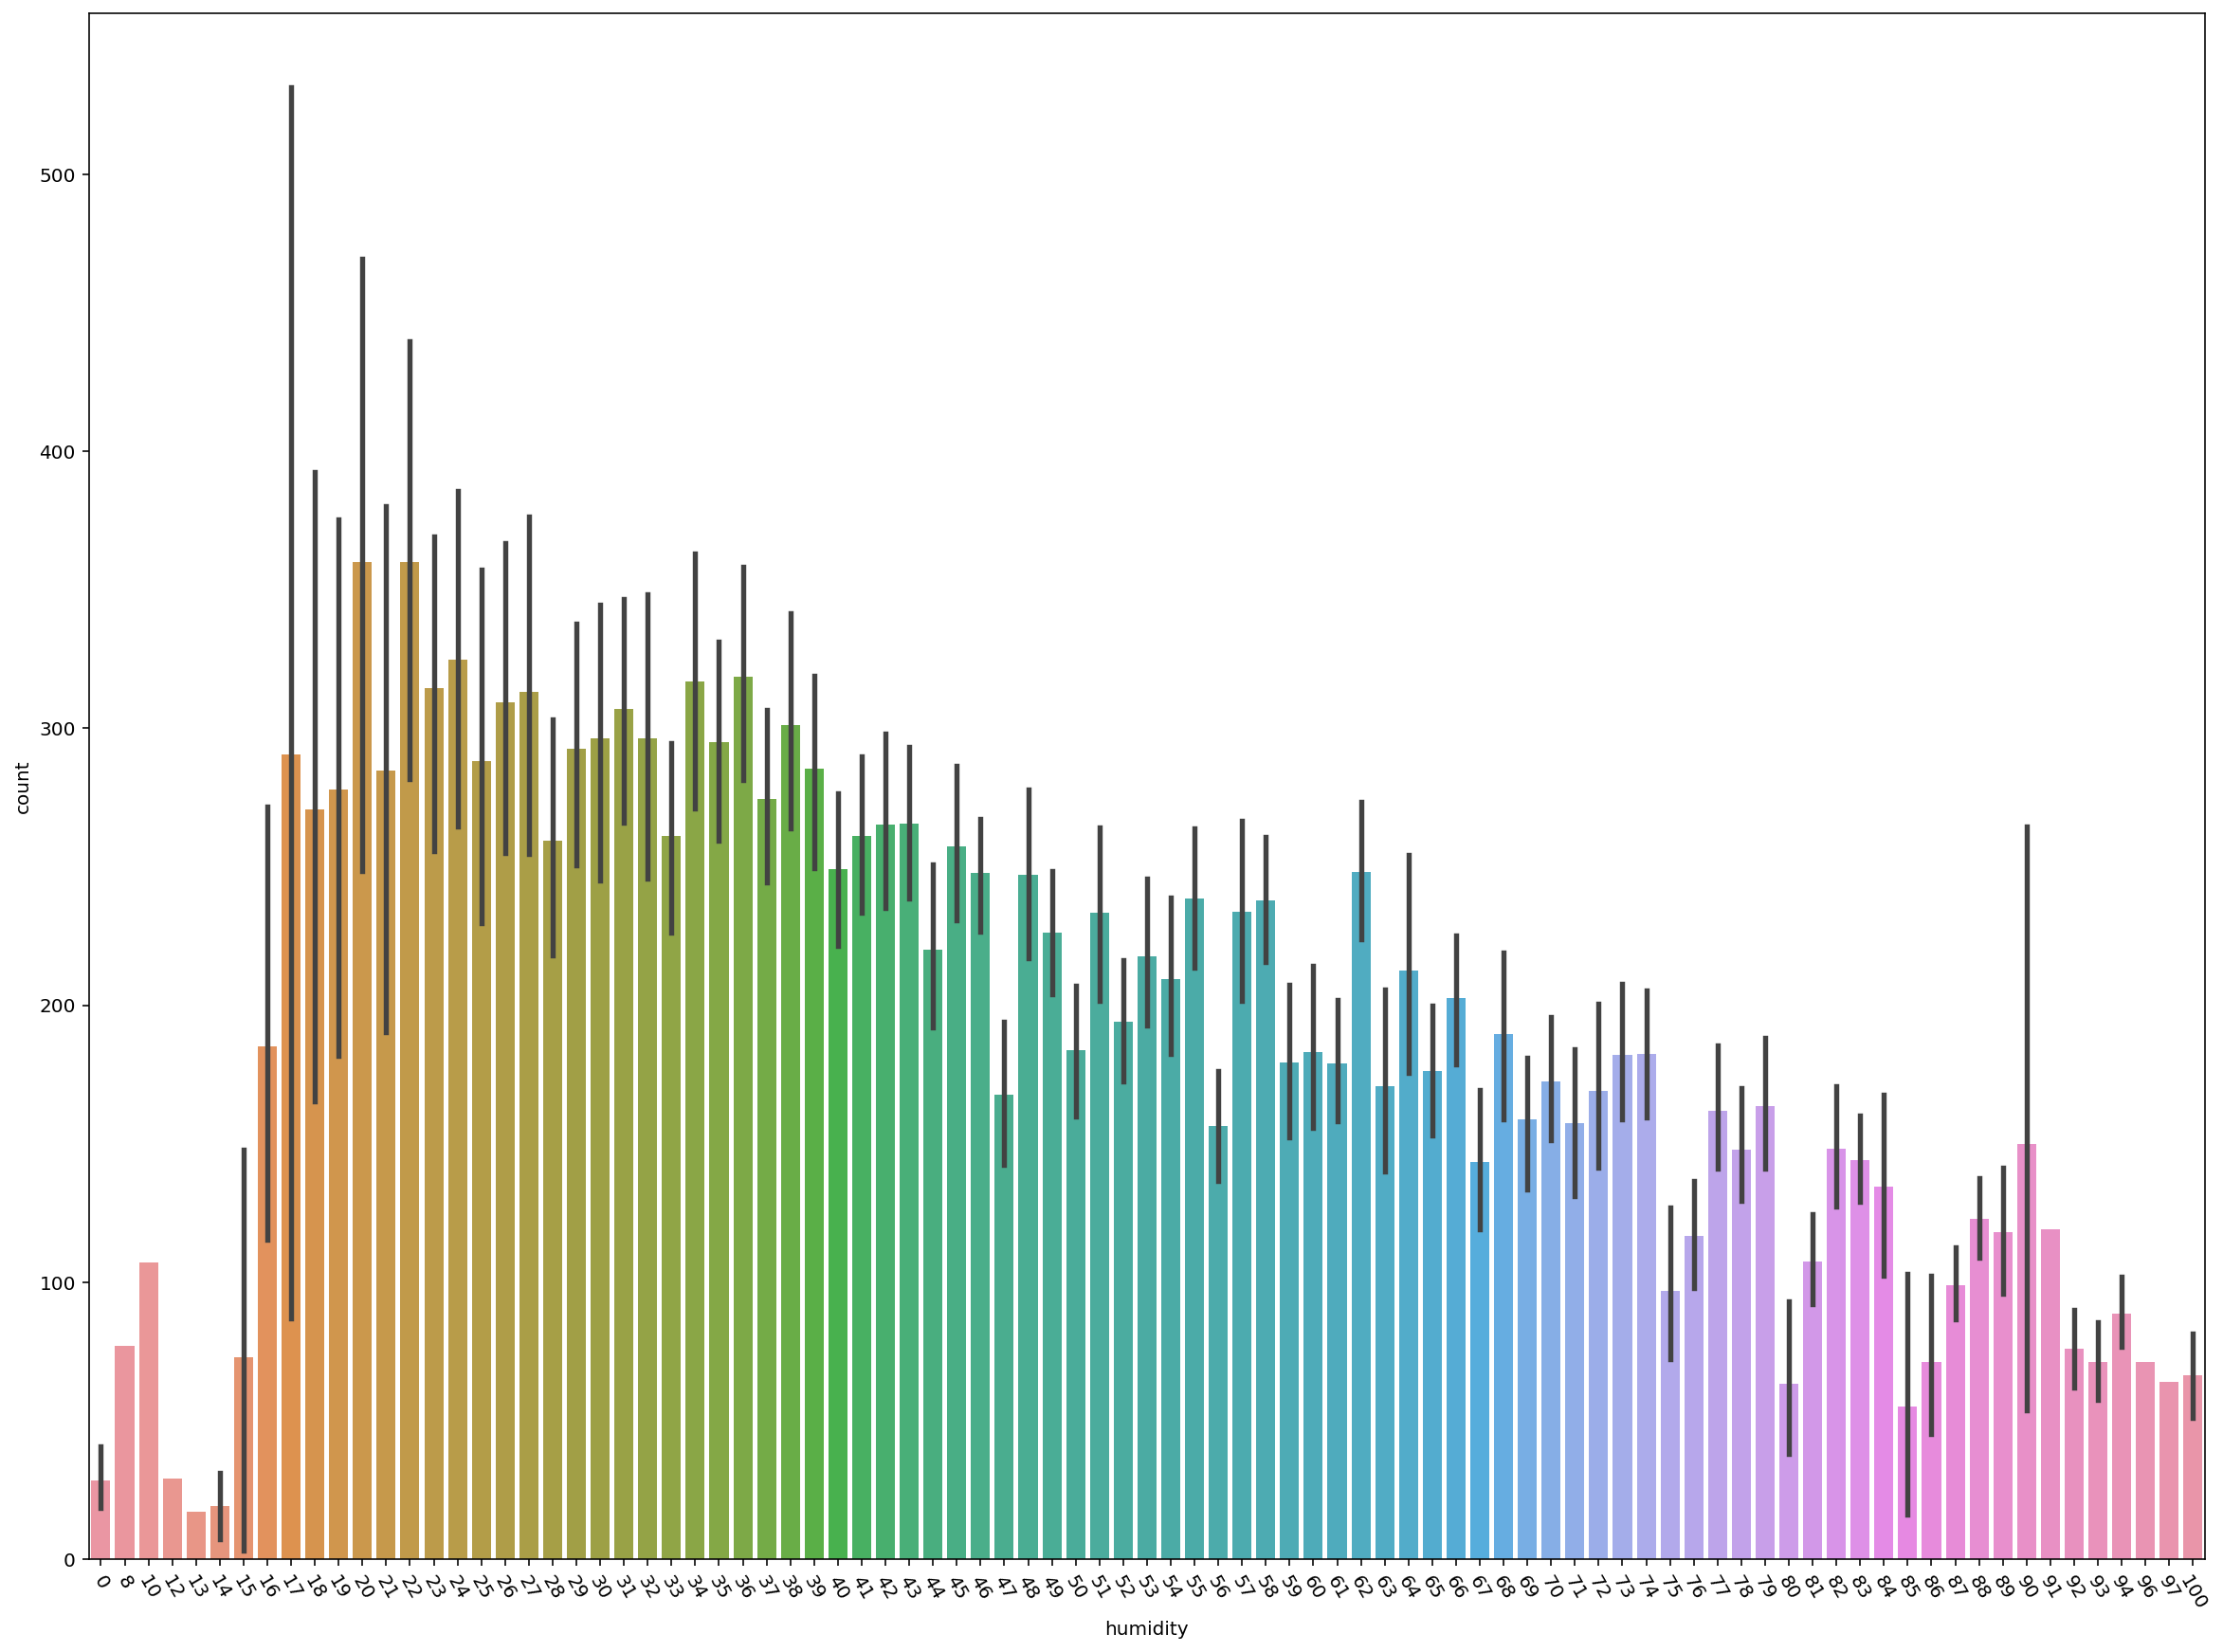

In [191]:
fig = plt.figure(figsize=(20,15))
sns.barplot( x = bike_sharing_dumm['humidity'], y = bike_sharing_dumm['count'] )
plt.xticks(rotation = - 60 )
plt.show()

In [183]:
bike_sharing_dumm.corrwith(bike_sharing_dumm['count'])

temp         0.394454
atemp        0.389784
humidity    -0.317371
windspeed    0.101369
count        1.000000
               ...   
season_4     0.023704
weather_1    0.105246
weather_2   -0.041329
weather_3   -0.117519
weather_4   -0.001459
Length: 83, dtype: float64

#### 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

In [204]:
bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [205]:
good_day = bike_sharing[ (bike_sharing["weather"] == 1) & (bike_sharing["dayofweek"] == 0) & (bike_sharing["hour"] == 15) ]

good_day = pd.get_dummies(good_day, columns = ['year', 'month', 'day', 'minute', 'second', 'holiday', 'workingday', 'season'])
good_day.drop(columns=["datetime", "casual","registered", "weather", "dayofweek","hour","minute_0","second_0" ],inplace=True)
good_day.head()

,temp,atemp,humidity,windspeed,count,year_2011,year_2012,month_1,month_2,month_3,...,day_18,day_19,holiday_0,holiday_1,workingday_0,workingday_1,season_1,season_2,season_3,season_4
60,10.66,12.120,30,16.9979,72,1,0,1,0,0,...,0,0,1,0,0,1,1,0,0,0
750,22.96,26.515,21,43.9989,90,1,0,0,1,0,...,0,0,1,0,0,1,1,0,0,0
1034,13.94,15.150,31,26.0027,96,1,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
1197,15.58,19.695,37,11.0014,101,1,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
1410,31.16,33.335,23,36.9974,143,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


In [207]:
X = good_day.drop(columns='count')
y = good_day['count']
print(X.shape)
print(y.shape)

train_input, test_input, train_target, test_target = train_test_split(X, y, random_state = 42)

lr = LinearRegression()
lr.fit(train_input, train_target)
pred = lr.predict(test_input)

mse = mean_squared_error(test_target, pred)
rmse = mean_squared_error(test_target, pred)**0.5
print(mse)
print(rmse)

(43, 45)
(43,)
56019.03847323123
236.68341402225724


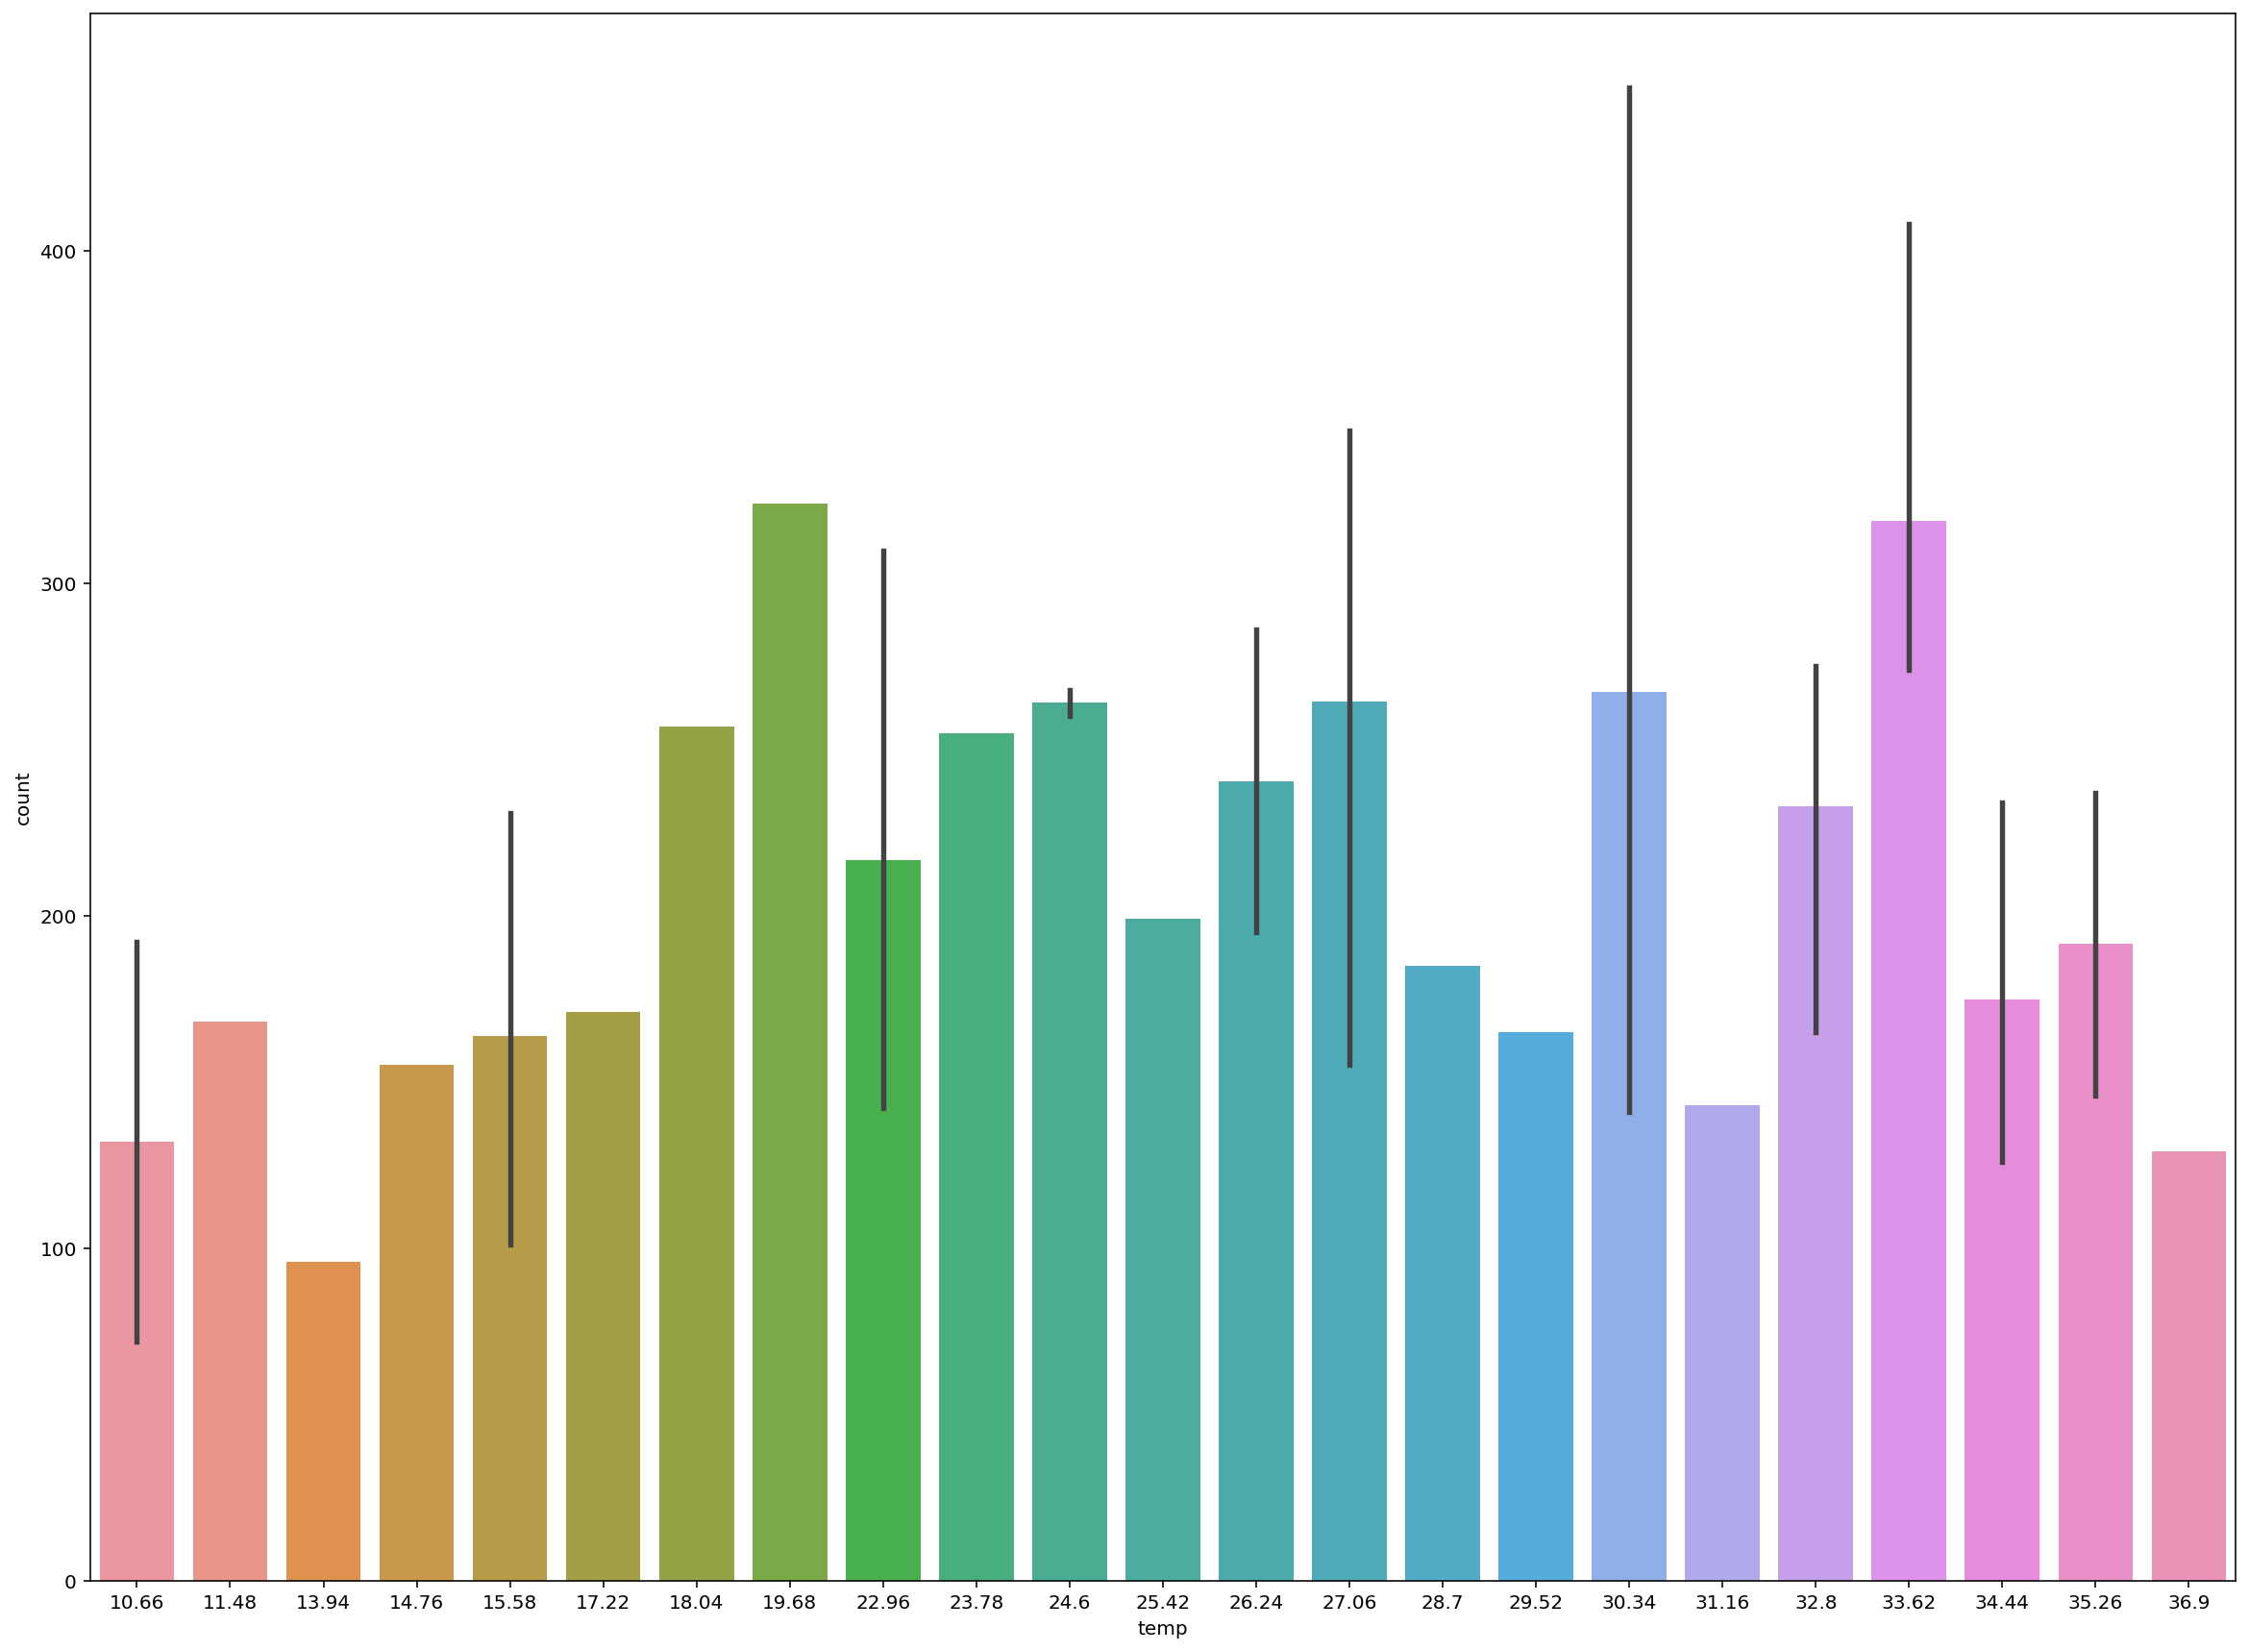

In [208]:
fig = plt.figure(figsize=(20,15))
sns.barplot( x = good_day['temp'], y = good_day['count'] )
plt.show()

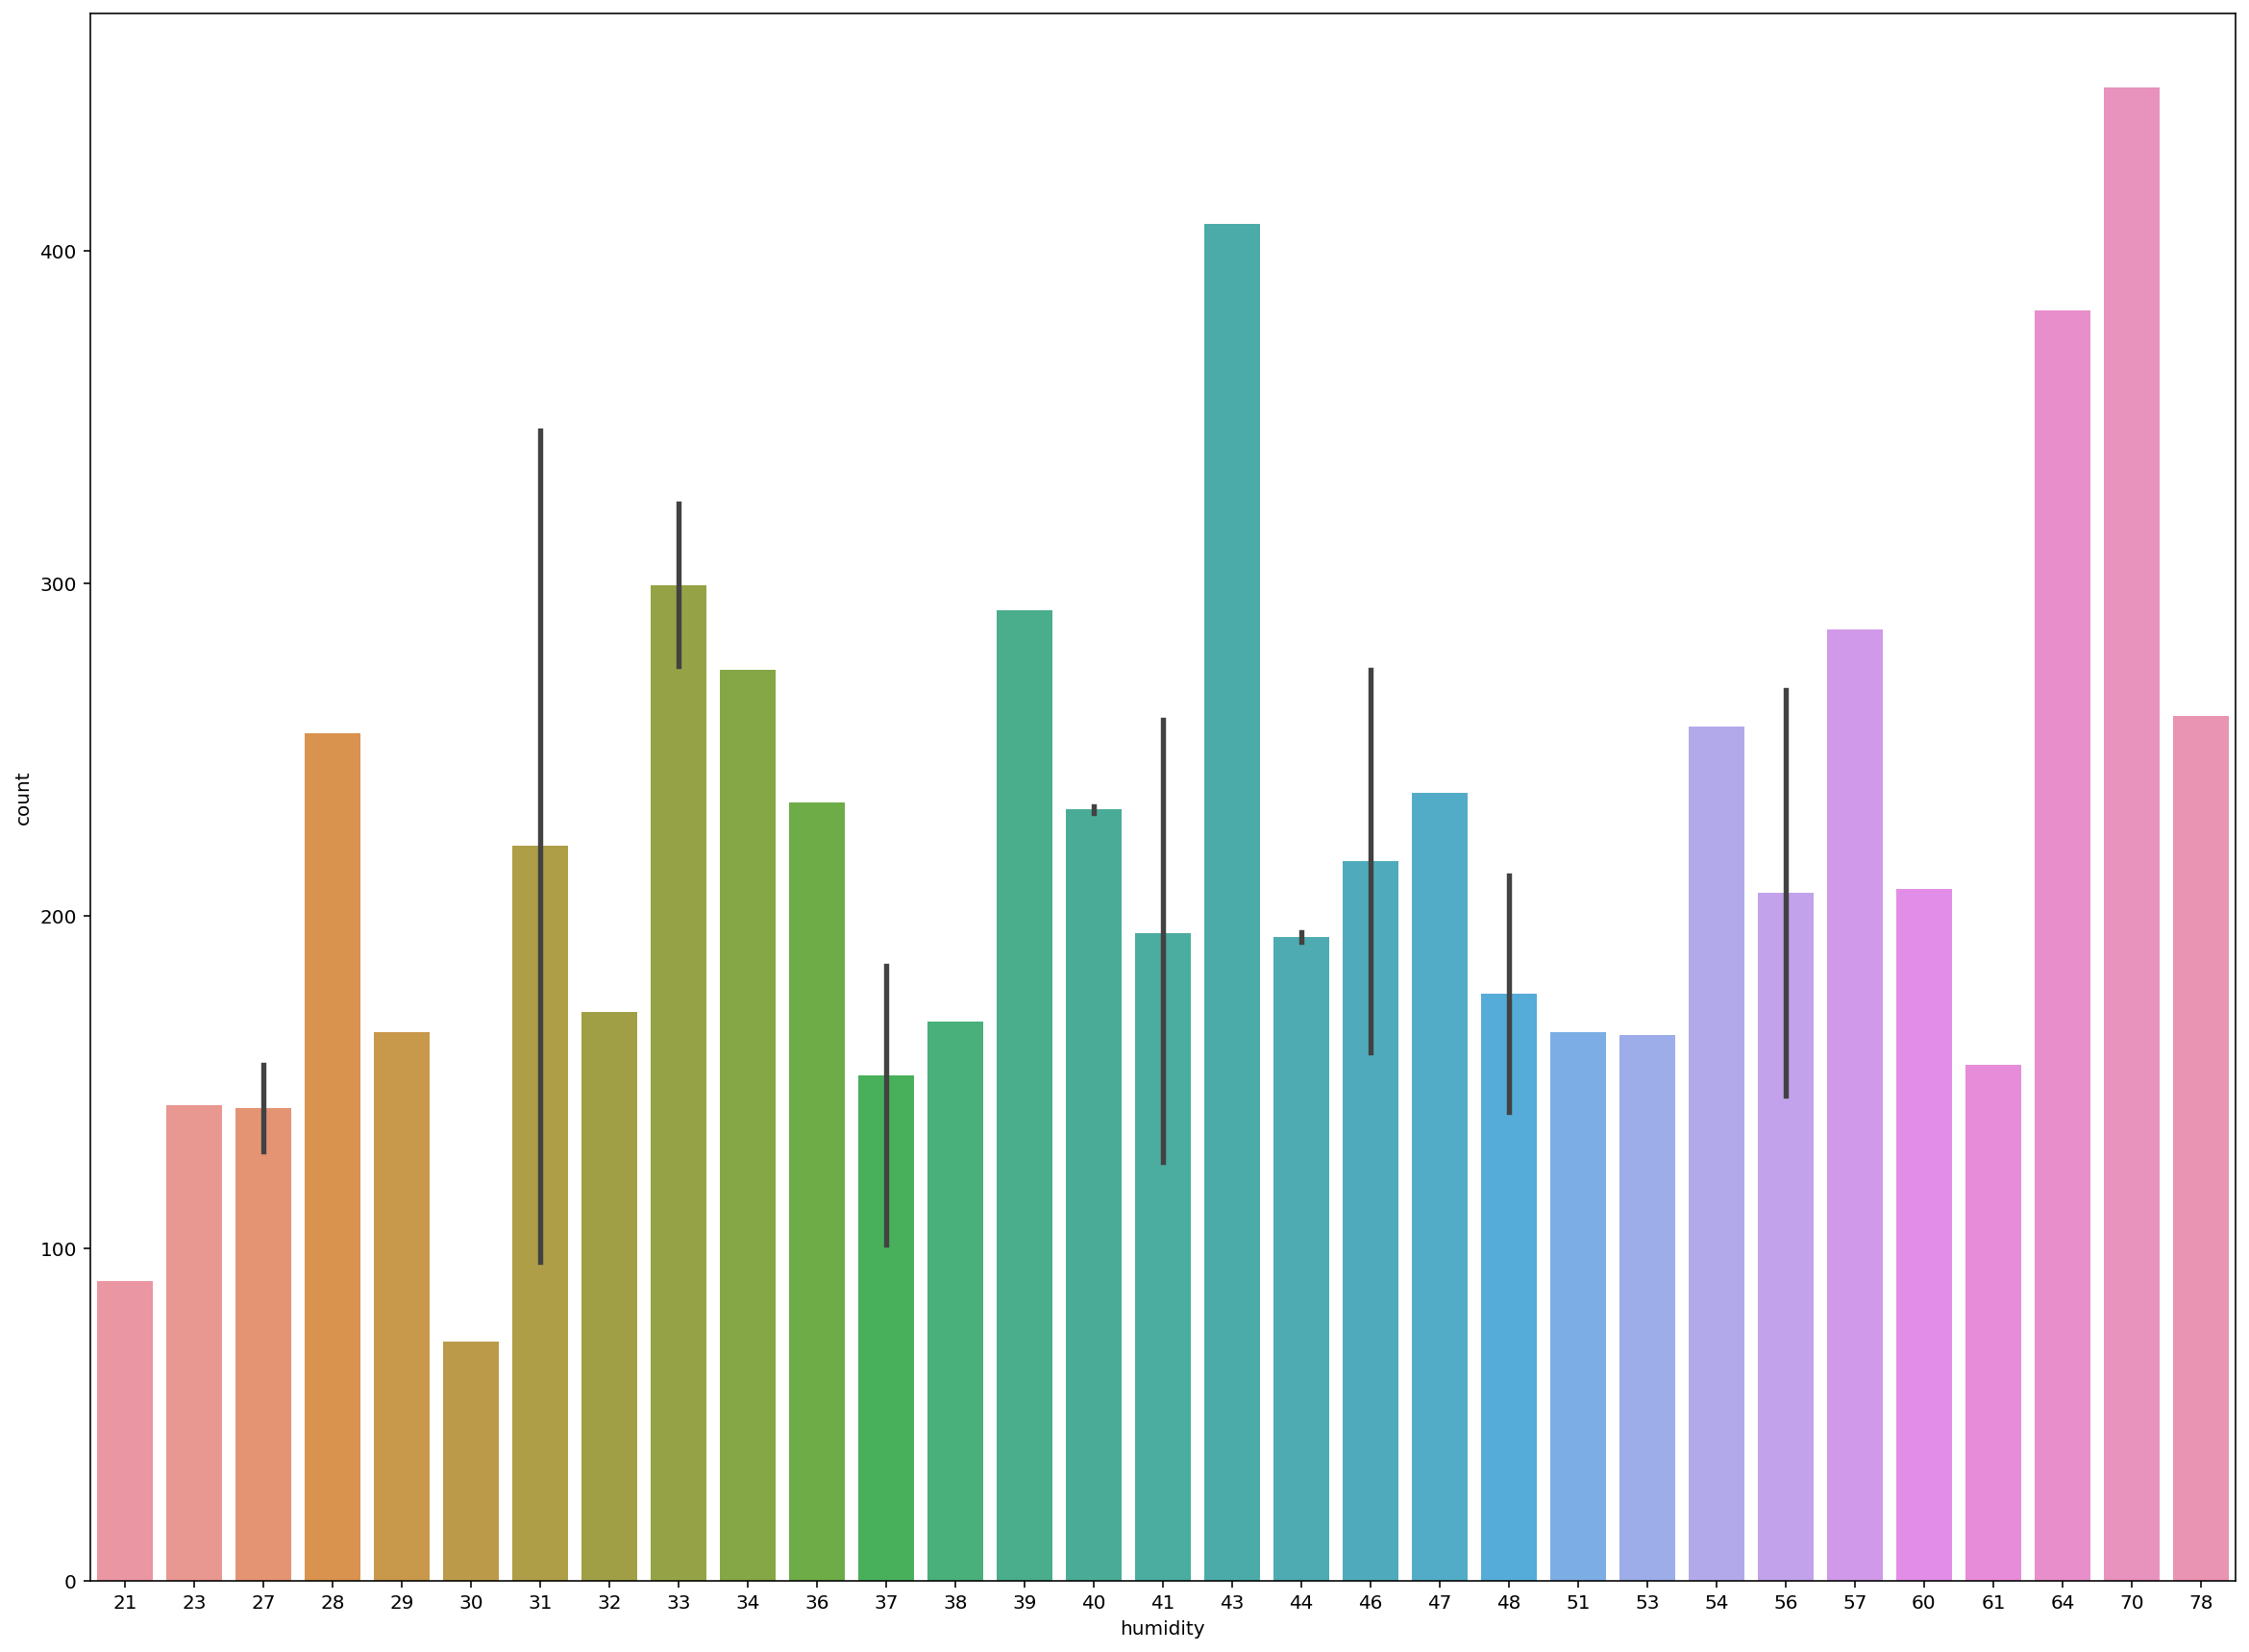

In [209]:
fig = plt.figure(figsize=(20,15))
sns.barplot( x = good_day['humidity'], y = good_day['count'] )
plt.show()

In [159]:
good_day.corrwith(good_day['count'])

temp            0.244704
atemp           0.266266
humidity        0.391506
windspeed      -0.137393
count           1.000000
year_2011      -0.604274
year_2012       0.604274
month_1        -0.232379
month_2        -0.249800
month_3        -0.138049
month_4         0.053912
month_5        -0.137650
month_6         0.038621
month_7         0.098043
month_8        -0.054967
month_9         0.393704
month_10        0.049686
month_11        0.137848
month_12       -0.004319
day_1          -0.158538
day_2           0.019521
day_3           0.156337
day_4           0.215134
day_5           0.029191
day_6          -0.038565
day_7          -0.216386
day_8          -0.164059
day_9           0.031245
day_10          0.240845
day_11         -0.108251
day_12          0.197713
day_13         -0.034210
day_14         -0.282465
day_15          0.082565
day_16          0.008062
day_17         -0.013140
day_18         -0.094121
day_19          0.061608
holiday_0      -0.466840
holiday_1       0.466840


# 회고

당뇨병 수치 데이터와 자전거 대여량 데이터셋에 다변량 선형회귀 모델을 적용해서 테스트 데이터 셋을 얼마나 잘 예측했는지 확인해보았다.

Datasets summary
1. 당뇨병 수치 데이터는 442개의 샘플에 대하여 10개의 feature와 당뇨병 수치데이터를 타겟으로 하는 구성
2. 자전거 대여량 데이터셋은 10886개의 샘플에 대하여 14개의 feature로부터 자전거 대여량을 타겟으로하는 구성

당뇨병 수치 데이터는 11개의 feature 중에서 타겟을 제외한 10개의 feature들은 모두 연속형 데이터로 정규화까지 되어있는 데이터셋이다. 자전거 대여량 데이터셋은 15개의 feature 중에서 타겟을 제외한 14개의 feature들은 datetime 객체, 범주형, boolean형, 연속형의 다양한 데이터 타입들이 있으며, datetime feature는 년월일시분초를 하나의 객체로 표현한 데이터 타입이였고, season, weather feature는 범주형, holiday, workingday feature는 boolean형, 그리고 나머지는 연속형 데이터 타입으로 구성되어 있었다.

당뇨병 수치 데이터를 타겟과 feature들로 나누었다. 앞선 노드를 바탕으로 manually 작성한 선형모델과 mean-squred error로 정의한 손실함수, 그리고 기울기 계산 함수를 구축하고 learning rate를 0.01에 iteration을 1000번 수행해서 훈련 데이터 세트를 선형 모델에 적용해서 도출된 loss값은 '2949.3086'이다. 1000번 iteration동안 loss가 줄어드는 정도를 시각화 해보았으며, 최종적으로 얻은 파라미터 W와 b도 확인했다. 테스트 데이터 세트로 manually 구축한 모델에 적용해보았을 때 loss값은 '2867.3114'로 확인됬으며, 훈련 데이터 세트와 테스트 데이터 세트 모두 루브릭의 기준인 loss값 3000보다 이하인 값이였다. 정답 데이터와 예측한 데이터를 scatter plotting해보았을 때, 두 데이터의 분포가 크게 다르지 않고 많이 겹쳐 있다는 것을 확인 했다.

또한 당뇨병 수치와 10가지 feature들과의 상관 관계 분석을 수행하고 상관관계 절대값이 0.4미만인 4개의 age, sex, s1, s2 feature를 제외하고 6개의 feature를 바탕으로 선형모델에 적용하여 loss값을 계산해보았지만, 루브릭에서 제시한 기준 3000이하인 값이 나오지 않았지만, 정답 데이터와 예측한 데이터사이의 시각화는 확실히 선형 상관관계를 보이는 것을 확인 할 수 있었다.

루브릭에서 제시한 loss값의 기준 3000이하인 값이 아닌, 최대한으로 한자리 수를 목표로 loss값을 줄이고 싶었으나 쉽지 않았고, 어떤 블로그에서 target의 값도 정규화를 해보라는 조언을 듣고(해당 블로그의 링크를 다시 찾을 수 없었다. 그리고 해당 블로그에서는 단순히 정규화 방법을 듣도보지도 못한 평균값만 빼는 방법을 제시했다.) 아래와 같은 기준으로 평균과 분산을 사용하여 target을 정규화하였다.

\begin{equation*}
\frac{y - \mu}{\sqrt{\sigma}}
\end{equation*}

훈련 및 테스트 데이터 세트에 둘 다 37~38까지 loss값을 줄였지만, 한 자리 수 까지는 못 줄여서 아쉬웠다. 그리고 10개의 feature에 수행됬던 것과 같은 정규화 기준으로 target을 정규화하는 방법이 가장 신뢰할 수 있는 과정이었겠지만, 수행됬던 정규화 방법을 알 수 없었기에 임의대로 정규화를 수행했다. 평균과 분산으로 정규화하는 방식은 일반적으로 수행되는 방법이기에 크게 feature 정규화방식의 과정과 결과가 다르지 않을 것이라고 생각한다.

자전거 대여량 데이터는 해당 노드에서 제시한 과제 이외에, 노드 제목 대로 "날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?"에 대한 결과를 확인해보고자 추가적인 데이터 전처리 및 시각화를 진행하였다. 

먼저 주어진 과제대로 datetime컬럼을 연, 월, 일, 시, 분, 초의 6가지의 컬럼으로 나누고, 추가적으로 요일 정보가 담긴 컬럼도 추가했다. 

datetime의 각 컬럼의 자전거 대여량은 해당 컬럼안의 각 카테고리 별로 큰 차이가 없었다. 시간 컬럼의 새벽 3시에는 자전거 대여량이 감소세를 보이고, 다른 시간대에는 동일한 대여량을 확인할 수 있었다. 상식적으로 시간에 따라 대여량이 다를 줄 알았는데, 데이터상에서는 시간에 크게 관계없이 일정랑 대여량 값을 보여주어서 공유가 아닌 렌탈개념으로 자전거를 대여하는 것이 아닌지에 대한 의문이 생겼었다.

자전거 대여량 데이터에서 학습에 사용하는 feature와 정답 클래스인 target으로 나누기 전에, 블로그를 참고하여 수치로 그룹핑한 feature에 대해 원 핫 인코딩을 수행했고 불필요한 datetime, casual, registered 컬럼을 삭제했다. 원 핫 인코딩으로 인해 feature 수가 82개로 증가하였다. sci-kit learn에서 제공하는 선형회귀 메서드인 LinearRegression를 사용하여 모델에 데이터를 학습시키고 mean_squared_error메서드로 MSE, RMSE를 계산했으며, 루브릭에서 제시한 기준인  RMSE 150이하인 값인 RMSE 100 을 도출하였다. 

각각 기온과 습도에 따른 자전거 대여량을 시각화해서 살펴보았다. 기온이 36.08도 까지는 기온 상승과 비례하여 자전거 대여량이 증가하는 것을 확인 할 수 있지만, 그 이후 온도에서는 자전거 대여량이 감소세를 보였다. 습도는 14까지는 자전거 대여량이 100대 이하였다가, 습도 15부터 17, 22까지는 습도가 증가함에 따라 자전거 대여량이 증가세를 보이다가 그 이후부터는 습도가 증가함에 따라 대여량의 감소가 이어졌다.

기온과 습도에 따른 대여량을 비교한 시각화에서 알 수 있는 사실은, 기온 36.08까지는 온도가 증가함에 따라 대여량도 증가하는 추세를 확인할 수 있고, 습도 17~22사이일 때 대여량이 가장 많다는 것을 확인 할수 있으며, 습도가 14 이하로 매우 건조할 때나 습도가 80 이상으로 매우 습할 때는 대여량이 적어진다는 것을 확인할 수 있다. 앞서 분석한 결론을 바탕으로 고객이 적정 온도와 습도에서 자전거를 만족하면서 이용할 때의 대여량 수치를 200대로 가정한다면, 이때를 전후로 프로모션을 시행해서 자전거 대여량을 증가 시킬 수 있을 것으로 생각해볼 수 있다.

In [210]:
마지막으로 자전거 대여량 프로젝트의 제목대로 "날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?"을 알아보기 위해서 맑은 날(weather == 1), 월요일(dayofweek == 0), 오후 세 시(hour == 15)에 해당하는 데이터만 필터링하고, weather, dayofweek, hour 컬럼을 제외한 컬럼 중에서 수치로 그룹핑한 feature에 대해 앞서 처리한 것과 같이 원 핫 인코딩을 수행했다.

SyntaxError: invalid syntax (568016815.py, line 1)